In [27]:
# ‚öôÔ∏è ÂøÖË¶Å„É©„Ç§„Éñ„É©„É™
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from types import SimpleNamespace
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import ot
from ot.unbalanced import sinkhorn_unbalanced
import os

In [28]:
# ‚îÄ‚îÄ „Éï„Ç©„É≥„ÉàË®≠ÂÆöÔºàÊó•Êú¨Ë™û„É©„Éô„É´Áî®Ôºâ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
if os.path.exists(font_path):
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams["font.family"] = font_prop.get_name()
else:
    font_prop = None

# ========= notebook parameters =========
args = SimpleNamespace(
    curr         = "../../data/shared/embeddings.npy",   # Êó¢Â≠ò„Çµ„Éº„Éì„Çπ„ÅÆÂüã„ÇÅËæº„Åø (n_services √ó D)
    fut          = "../VAE/emb_new.npy",      # Êñ∞Ë¶è„Çµ„É≥„Éó„É´„ÅÆÂüã„ÇÅËæº„Åø   (N_new √ó D)
    # segm         = "../../data/shared/user_segments.csv",# Â∏ÇÂ†¥„Çª„Ç∞„É°„É≥„ÉàÔºàÂ≠¶Áîü/È´òÈΩ¢ËÄÖ„Å™„Å©Ôºâ
    mass_curr    = None,
    plot_detail  = True,
    sensitivity_analysis = True,   # ÊÑüÂ∫¶ÂàÜÊûêON/OFF
)

In [29]:
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 1. Âüã„ÇÅËæº„Åø„É≠„Éº„Éâ & Ê®ôÊ∫ñÂåñ
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
X_curr = np.load(args.curr)
Y_fut  = np.load(args.fut)

scaler = StandardScaler()
X_curr = scaler.fit_transform(X_curr)
Y_fut  = scaler.transform(Y_fut)

In [38]:
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 2. Ë≥™Èáè„Éô„ÇØ„Éà„É´„ÅÆÊßãÈÄ†ÔºöÊó¢Â≠ò„Çµ„Éº„Éì„ÇπÔºãÈùû„É¶„Éº„Ç∂„ÉºÔºãÊÆãÁïô„Éé„Éº„Éâ
#    + Â∏ÇÂ†¥„Çª„Ç∞„É°„É≥„ÉàÂØæÂøú
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
xls      = pd.ExcelFile("../../data/ÂÆöÈ°çÂà∂ÂãïÁîªÈÖç‰ø°.xlsx")
df_raw   = pd.read_excel(xls, sheet_name="data")
format_df= pd.read_excel(xls, sheet_name="Format")

sq6_1 = format_df[format_df["Question"].astype(str).str.startswith("SQ6_1[")][["Question","Title"]].dropna()
code_title = {
    int(q.split("[")[1].split("]")[0]): title
    for q, title in zip(sq6_1["Question"], sq6_1["Title"])
}
title_code = {v:k for k,v in code_title.items()}

counts = df_raw["SQ6_2"].value_counts().sort_index()
shares = counts / counts.sum()

import pickle
feat_df = pd.read_pickle("../../data/shared/feat_df.pkl")
mass_curr = []
for svc in feat_df.index:
    code = title_code.get(svc)
    mass_curr.append(shares.get(code, 0.0))
mass_curr = np.array(mass_curr, dtype=float)
service_names = feat_df.index.tolist()

# Èùû„É¶„Éº„Ç∂„Éº„ÅÆË≥™Èáè„ÇíÂ∏ÇÂ†¥Ë™øÊüª„ÇÑÂ§ñÈÉ®Áµ±Ë®à„Åã„ÇâÊ±∫„ÇÅ„Çã
# „Åì„Åì„Åß„ÅØ‰æã„Å®„Åó„Å¶„Çª„Ç∞„É°„É≥„ÉàÂà•„ÅÆÊú™Âà©Áî®Áéá„Çí‰ªÆÂÆö
# segment_df = pd.read_csv("../../data/shared/user_segments.csv")  # ‰æãÔºöÂ≠¶Áîü,Á§æ‰ºö‰∫∫,È´òÈΩ¢ËÄÖ„Åî„Å®„ÅÆ‰∫∫Âè£ÊØî„Å®Êú™Âà©Áî®Áéá
# seg_population = segment_df["population"].values
# seg_nonuser_rate = segment_df["nonuser_rate"].values

# ‚îÄ‚îÄ 1) ÈùûÂà©Áî®Áéá (% ‚ûî 0-1) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
#70Ê≠≥‰ª•‰∏ä„ÅÆÈ´òÈΩ¢ËÄÖÂ±§„ÅÆÈùûÂà©Áî®Áéá„ÅØ‰ªÆÂÆö„ÅÆÊï∞ÂÄ§
nonuser_rate = {
    "10s":0.036,"20s":0.005,"30s":0.012,"40s":0.035,
    "50s":0.072,"60s":0.211,"70s":0.298,"80s":0.374,"90s":0.486
}
population_thousand = {
    "10s":5185+5457, "20s":6260+6519, "30s":6395+6871, "40s":7631+8745,
    "50s":9788+8490, "60s":7571+7268, "70s":8198+7886, "80s":6138+3944,
    "90s":2088+635   # 90 Ê≠≥‰ª•‰∏ä
}

# ÂÆü‰∫∫Êï∞„Å´Â§âÊèõÔºà√ó1_000Ôºâ
population = {k: v * 1_000 for k, v in population_thousand.items()}

# ‚îÄ‚îÄ 3) DataFrame „ÇíÂàóÊñπÂêë„Åß‰Ωú„Çã  ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
import pandas as pd

df = pd.DataFrame({
    "population": pd.Series(population, dtype=float),
    "nonuser_rate": pd.Series(nonuser_rate, dtype=float)
})

# ‚îÄ‚îÄ 4) Âä†ÈáçÂπ≥Âùá„ÅßÂÖ®ÂõΩÈùû„É¶„Éº„Ç∂„ÉºÁéá„ÇíÁÆóÂá∫ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
nonuser_mass = (df["population"] * df["nonuser_rate"]).sum() / df["population"].sum()
print(f"ÂÖ®ÂõΩ OTT Èùû„É¶„Éº„Ç∂„ÉºÁéá = {nonuser_mass:.2%}")   # ‰æãÔºö6.47 %

# ‚îÄ‚îÄ 5) OT Áî®„ÅÆË≥™Èáè„Éô„ÇØ„Éà„É´„Å´ÁµÑ„ÅøËæº„ÇÄ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 2) ‚îÄ‚îÄ Ë≥™Èáè„Éô„ÇØ„Éà„É´ÔºàÈáçË§á„Å™„ÅèÔºëÊú¨„ÅßÔºâ -----------------
residual_mass = 0.138 # ÊÆãÁïôÂ±§„ÅÆË≥™ÈáèÔºà‰æãÔºö13.8%Ôºâ
a = np.append(mass_curr, [nonuser_mass, residual_mass])
a = np.maximum(a, 1e-12);  a /= a.sum()           # Ê≠£Ë¶èÂåñ
all_source_names = service_names + ["(Èùû„É¶„Éº„Ç∂„Éº)","(ÊÆãÁïôÂ±§)"]

n = X_curr.shape[0]
m = Y_fut.shape[0]

# Ë§áÊï∞ARPU„ÄÅ„Çµ„Éº„Éì„Çπ„Åî„Å®„ÅÆÂçò‰æ°„ÇÇËÄÉÊÖÆÔºà‰æãÔºâ
# arpu_list = np.loadtxt("../../data/shared/arpu.csv")  # Êñ∞„Çµ„Éº„Éì„Çπ„Åî„Å®„ÅÆARPU‰ªÆÂÆöÔºàÂÜÜÔºâ

# arpu.csv „Çí„Åæ„Å†‰ΩúÊàê„Åó„Å¶„ÅÑ„Å™„ÅÑÂ†¥Âêà„ÄÅ‰ªÆ„Éá„Éº„Çø„ÅßÈÄ≤„ÇÅ„Çã
# ‰ªÆ„ÅÆ ARPU „Éá„Éº„Çø
arpu_list = np.array([1200, 1500, 1000, 1300, 1600])  # „Çµ„Éº„Éì„Çπ„Åî„Å®„ÅÆÊúàÈ°çÂçò‰æ°Ôºà‰ªÆÔºâ

# „Çª„Ç∞„É°„É≥„ÉàÂà•ÂàÜÊûêÔºàÂ≠¶Áîü„ÉªÁ§æ‰ºö‰∫∫„ÉªÈ´òÈΩ¢ËÄÖ‚Ä¶Ôºâ„ÅÆ„É´„Éº„Éó„Å´„ÇÇÂØæÂøúÂèØËÉΩ

# Ë§áÊï∞Ë∑ùÈõ¢Ôºà„Ç≥„Çµ„Ç§„É≥√óŒ±Ôºã‰æ°Ê†ºÂ∑Æ√óŒ≤Ôºã„Éñ„É©„É≥„ÉâÂ∑Æ√óŒ≥Ôºâ„ÅßË§áÂêà„Ç≥„Çπ„Éà
def composite_distance(X, Y, cosine_w=0.6, price_w=0.3, brand_w=0.1):
    # ‰ªÆÔºöprice_diff, brand_diff„ÅØ„Éá„Éº„Çø„Åå„ÅÇ„Çå„Å∞Ë®àÁÆó
    D_cos = pairwise_distances(X, Y, metric="cosine")
    D_price = np.zeros_like(D_cos)  # ‰æ°Ê†ºÂ∑Æ„ÅåÁÑ°„ÅÑÂ†¥Âêà„ÅØ0
    D_brand = np.zeros_like(D_cos)
    return (cosine_w * D_cos + price_w * D_price + brand_w * D_brand)

# ---------------- Â§ñÈÉ®„Ç¢„É≥„Ç±„Éº„Éà -----------------
# „Éê„É™„Ç¢Âà•„Ç∑„Çß„Ç¢ (%)  √ó Èáç„Åø  „ÇíË∂≥„ÅóÂêà„Çè„Åõ„Å¶ raw „Çπ„Ç≥„Ç¢„Çí‰Ωú„Çã
barrier_share  = {"no_intent":0.437, "few_titles":0.278,
                  "procedure":0.12,  "price":0.10}
barrier_weight = {"no_intent":1.0,   "few_titles":0.7,
                  "procedure":0.5,   "price":0.5}

D_nonuser_base = sum(barrier_share[k]*barrier_weight[k] for k in barrier_share)   # ‚âí0.46
median_d = np.median(pairwise_distances(X_curr, metric="cosine"))  # ‚âí0.40
D_nonuser_norm = D_nonuser_base / median_d                         # ‚âí1.15


# „Éë„É©„É°„Éº„ÇøÊÑüÂ∫¶ÂàÜÊûêÁî®„ÅÆË®≠ÂÆö
param_grid = {
    "nonuser_mass"   : [nonuser_mass*0.7, nonuser_mass, nonuser_mass*1.3],
    "D_factor"       : [0.8, 1.0, 1.2],              # üî¥ ÂÄçÁéá„ÅßÂõû„Åô
    "residual_mass"  : [0.10, 0.14, 0.18],
    "eps"            : [0.1, 0.2, 0.3],
    "tau"            : [0.05, 0.1, 0.2]
}


#Â∏ÇÂ†¥Ë¶èÊ®°
# „Åô„Åß„Å´„ÅÇ„Çã df „Å´„ÅØ
#   df["population"]   ‚Ä¶ Âπ¥‰ª£Âà•‰∫∫Âè£Ôºà‰∫∫Ôºâ
#   df["nonuser_rate"] ‚Ä¶ ÈùûÂà©Áî®ÁéáÔºà0‚Äì1Ôºâ
# „ÅåÂÖ•„Å£„Å¶„ÅÑ„Çã

# ‚îÄ‚îÄ Âπ¥‰ª£Âà•„ÄåÂà©Áî®ËÄÖÊï∞„Äç„ÇíËøΩÂä† ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df["user_count"] = df["population"] * (1 - df["nonuser_rate"])

# ‚îÄ‚îÄ ÂÖ®‰ΩìÂ∏ÇÂ†¥„É¶„Éº„Ç∂„ÉºÊï∞„ÇíÁÆóÂá∫ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
total_market_size = int(df["user_count"].sum())

print(df)                           # ‰∏≠Ë∫´„ÇíÁ¢∫Ë™ç„Åó„Åü„ÅÑÂ†¥Âêà
print(f"‚ñ∂ total_market_size = {total_market_size:,} ‰∫∫")

total_market_size = int(df["user_count"].sum())

ÂÖ®ÂõΩ OTT Èùû„É¶„Éº„Ç∂„ÉºÁéá = 13.48%
     population  nonuser_rate  user_count
10s  10642000.0         0.036  10258888.0
20s  12779000.0         0.005  12715105.0
30s  13266000.0         0.012  13106808.0
40s  16376000.0         0.035  15802840.0
50s  18278000.0         0.072  16961984.0
60s  14839000.0         0.211  11707971.0
70s  16084000.0         0.298  11290968.0
80s  10082000.0         0.374   6311332.0
90s   2723000.0         0.486   1399622.0
‚ñ∂ total_market_size = 99,555,518 ‰∫∫


In [39]:



# =============================================================
# 3. Êñ∞„Çµ„Éº„Éì„ÇπÂÄôË£ú1„Å§„Åö„Å§„Å´ÂØæ„Åó„Å¶OT„ÇíÂÆüÊñΩ + „Éë„É©„É°„Éº„ÇøÊÑüÂ∫¶ÂàÜÊûê
# =============================================================

def run_ot_for_candidate(idx, nonuser_mass, D_factor, residual_mass, eps, tau):
    # Êñ∞„Çµ„Éº„Éì„Çπ„Éô„ÇØ„Éà„É´
    Y_single = Y_fut[idx].reshape(1, -1)
    # composite distance
    D_existing = composite_distance(X_curr, Y_single, cosine_w=0.7, price_w=0.2, brand_w=0.1)  # (n,1)
    # Èùû„É¶„Éº„Ç∂„Éº„Å®ÊÆãÁïôÂ±§„Åã„ÇâÊñ∞„Çµ„Éº„Éì„Çπ„Å∏„ÅÆ„Ç≥„Çπ„ÉàÔºàÁèæÂÆüÁöÑ„Å™„Çâ„Çª„Ç∞„É°„É≥„ÉàÂà•„Å´ÂàÜ„Åë„Å¶ÂÆüË£ÖÔºâ
    D_nonuser_arr = np.array([[D_nonuser_norm * D_factor]])
    D_resid_arr   = np.array([[2.0]])   # ÊÆãÁïôÂ±§„ÅØ„ÄåÁµ∂ÂØæÂãï„Åã„Å™„ÅÑ„Äç„ÅÆ„ÅßÂ§ß„Åç„ÇÅ„Ç≥„Çπ„Éà
    D = np.vstack([D_existing, D_nonuser_arr, D_resid_arr])  # (n+2, 1)
    D = D / np.median(D)

    # Ë≥™Èáè„Éô„ÇØ„Éà„É´
    a_vec = np.append(np.maximum(mass_curr, 1e-12), [nonuser_mass, residual_mass])
    a_vec /= a_vec.sum()

    b = np.array([1.0])  # 1„Çµ„Éº„Éì„Çπ„Å†„Åë„Å´1

    # OTË®àÁÆó
    T = sinkhorn_unbalanced(a_vec, b, D, reg=eps, reg_m=tau)
    inbound_total  = T.sum()
    inbound_users  = inbound_total * total_market_size

    from_existing  = T[:-2, 0].sum()
    from_nonuser   = T[-2, 0]
    from_residual  = T[-1, 0]
    bo_ratio = from_nonuser / inbound_total if inbound_total > 0 else 0
    residual_ratio = from_residual / inbound_total if inbound_total > 0 else 0

    # Novelty
    novelty = D_existing.min()

    # „Éñ„É´„Éº„Ç™„Éº„Ç∑„É£„É≥„Çπ„Ç≥„Ç¢
    blue_score = from_nonuser * novelty

    # Â£≤‰∏ä‰∫àÊ∏¨ÔºàÂçò‰æ°„ÅØÂÄôË£ú„Åî„Å®„Å´ÂèØÂ§âÔºâ
    try:
        arpu = arpu_list[idx]
    except:
        arpu = 1200
    estimated_sales = inbound_users * arpu

    return {
        "service": f"new{idx}",
        "from_existing": from_existing * total_market_size,
        "from_nonuser": from_nonuser * total_market_size,
        "from_residual": from_residual * total_market_size,
        "residual_ratio": residual_ratio,
        "total_inflow": inbound_users,
        "nonuser_ratio": bo_ratio,
        "novelty": novelty,
        "BlueOceanScore": blue_score,
        "estimated_sales": estimated_sales,
        "arpu": arpu,
        "eps": eps,
        "tau": tau,
        "nonuser_mass": nonuser_mass,
        "D_nonuser": float(D_nonuser_arr),
        "residual_mass": residual_mass
    }

# „Ç∞„É™„ÉÉ„Éâ„Çµ„Éº„ÉÅ„ÉªÊÑüÂ∫¶ÂàÜÊûê
if args.sensitivity_analysis:
    from itertools import product
    results = []
    for nonuser_mass, D_factor, residual_mass, eps, tau in product(
            param_grid["nonuser_mass"], param_grid["D_factor"],
            param_grid["residual_mass"], param_grid["eps"], param_grid["tau"]):
        print(f"Running for: nonuser={nonuser_mass:.2f}, D_nonuser={D_factor:.2f}, residual={residual_mass:.2f}, eps={eps:.2f}, tau={tau:.2f}")
        for idx in range(m):
            res = run_ot_for_candidate(idx, nonuser_mass, D_factor, residual_mass, eps, tau)
            results.append(res)
    df_result = pd.DataFrame(results)
    df_result.to_csv("results/scores_sensitivity.csv", index=False)
    # „Åì„Åì„ÅßÊúÄÂ§ßÂÄ§„ÉªÂÆâÂÆöÊÄß„Éª„Éë„É©„É°„Éº„ÇøÊÑüÂ∫¶„ÇíÂ§öËª∏„ÅßÂàÜÊûê
    # ‰æã„Åà„Å∞ pivot_table „ÇÑ„Éí„Éº„Éà„Éû„ÉÉ„Éó„Åß
else:
    # 1„Éë„Çø„Éº„É≥„Å†„Åë
    results = []
    for idx in range(m):
        res = run_ot_for_candidate(
            idx, nonuser_mass, D_nonuser=1.0, residual_mass=residual_mass,
            eps=0.2, tau=0.1)
        results.append(res)
    df_result = pd.DataFrame(results)
    df_result.to_csv("results/scores.csv", index=False)

Running for: nonuser=0.09, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.05
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.10
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.20
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.10, eps=0.20, tau=0.05
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.10, eps=0.20, tau=0.10
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.10, eps=0.20, tau=0.20
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.10, eps=0.30, tau=0.05
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.10, eps=0.30, tau=0.10


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=0.80, residual=0.10, eps=0.30, tau=0.20
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.14, eps=0.10, tau=0.05
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.14, eps=0.10, tau=0.10
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.14, eps=0.10, tau=0.20
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.14, eps=0.20, tau=0.05
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.14, eps=0.20, tau=0.10


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=0.80, residual=0.14, eps=0.20, tau=0.20
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.14, eps=0.30, tau=0.05
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.14, eps=0.30, tau=0.10
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.14, eps=0.30, tau=0.20
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.18, eps=0.10, tau=0.05
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.18, eps=0.10, tau=0.10
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.18, eps=0.10, tau=0.20
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.18, eps=0.20, tau=0.05


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=0.80, residual=0.18, eps=0.20, tau=0.10
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.18, eps=0.20, tau=0.20
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.18, eps=0.30, tau=0.05
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.18, eps=0.30, tau=0.10
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.18, eps=0.30, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.10, eps=0.10, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.10, eps=0.10, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.10, eps=0.10, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=1.00, residual=0.10, eps=0.20, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.10, eps=0.20, tau=0.10


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=1.00, residual=0.10, eps=0.20, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.10, eps=0.30, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.10, eps=0.30, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.10, eps=0.30, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.14, eps=0.10, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.14, eps=0.10, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.14, eps=0.10, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.14, eps=0.20, tau=0.05


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=1.00, residual=0.14, eps=0.20, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.14, eps=0.20, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.14, eps=0.30, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.14, eps=0.30, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.14, eps=0.30, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.18, eps=0.10, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.18, eps=0.10, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.18, eps=0.10, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=1.00, residual=0.18, eps=0.20, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.18, eps=0.20, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.18, eps=0.20, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.18, eps=0.30, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.18, eps=0.30, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.18, eps=0.30, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.10, eps=0.10, tau=0.05


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=1.20, residual=0.10, eps=0.10, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.10, eps=0.10, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.10, eps=0.20, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.10, eps=0.20, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.10, eps=0.20, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=1.20, residual=0.10, eps=0.30, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.10, eps=0.30, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.10, eps=0.30, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.14, eps=0.10, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.14, eps=0.10, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.14, eps=0.10, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=1.20, residual=0.14, eps=0.20, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.14, eps=0.20, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.14, eps=0.20, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.14, eps=0.30, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.14, eps=0.30, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.14, eps=0.30, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=1.20, residual=0.18, eps=0.10, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.18, eps=0.10, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.18, eps=0.10, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.18, eps=0.20, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.18, eps=0.20, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.18, eps=0.20, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.18, eps=0.30, tau=0.05


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=1.20, residual=0.18, eps=0.30, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.18, eps=0.30, tau=0.20
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.05
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.10
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.20
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.10, eps=0.20, tau=0.05


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=0.80, residual=0.10, eps=0.20, tau=0.10
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.10, eps=0.20, tau=0.20
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.10, eps=0.30, tau=0.05
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.10, eps=0.30, tau=0.10
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.10, eps=0.30, tau=0.20
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.14, eps=0.10, tau=0.05
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.14, eps=0.10, tau=0.10
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.14, eps=0.10, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=0.80, residual=0.14, eps=0.20, tau=0.05
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.14, eps=0.20, tau=0.10
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.14, eps=0.20, tau=0.20
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.14, eps=0.30, tau=0.05
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.14, eps=0.30, tau=0.10
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.14, eps=0.30, tau=0.20
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.18, eps=0.10, tau=0.05
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.18, eps=0.10, tau=0.10


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=0.80, residual=0.18, eps=0.10, tau=0.20
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.18, eps=0.20, tau=0.05
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.18, eps=0.20, tau=0.10
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.18, eps=0.20, tau=0.20
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.18, eps=0.30, tau=0.05
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.18, eps=0.30, tau=0.10
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.18, eps=0.30, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.10, eps=0.10, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.10, eps=0.10, tau=0.10


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=1.00, residual=0.10, eps=0.10, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.10, eps=0.20, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.10, eps=0.20, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.10, eps=0.20, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.10, eps=0.30, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.10, eps=0.30, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.10, eps=0.30, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=1.00, residual=0.14, eps=0.10, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.14, eps=0.10, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.14, eps=0.10, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.14, eps=0.20, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.14, eps=0.20, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.14, eps=0.20, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.14, eps=0.30, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.14, eps=0.30, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.14, eps=0.30, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=1.00, residual=0.18, eps=0.10, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.18, eps=0.10, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.18, eps=0.10, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.18, eps=0.20, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.18, eps=0.20, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.18, eps=0.20, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.18, eps=0.30, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.18, eps=0.30, tau=0.10


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=1.00, residual=0.18, eps=0.30, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.10, eps=0.10, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.10, eps=0.10, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.10, eps=0.10, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.10, eps=0.20, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.10, eps=0.20, tau=0.10


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=1.20, residual=0.10, eps=0.20, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.10, eps=0.30, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.10, eps=0.30, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.10, eps=0.30, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.14, eps=0.10, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.14, eps=0.10, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.14, eps=0.10, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=1.20, residual=0.14, eps=0.20, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.14, eps=0.20, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.14, eps=0.20, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.14, eps=0.30, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.14, eps=0.30, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.14, eps=0.30, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=1.20, residual=0.18, eps=0.10, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.18, eps=0.10, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.18, eps=0.10, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.18, eps=0.20, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.18, eps=0.20, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.18, eps=0.20, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.18, eps=0.30, tau=0.05


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=1.20, residual=0.18, eps=0.30, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.18, eps=0.30, tau=0.20
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.05
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.10
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.20
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.10, eps=0.20, tau=0.05


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=0.80, residual=0.10, eps=0.20, tau=0.10
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.10, eps=0.20, tau=0.20
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.10, eps=0.30, tau=0.05
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.10, eps=0.30, tau=0.10
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.10, eps=0.30, tau=0.20
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.14, eps=0.10, tau=0.05


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=0.80, residual=0.14, eps=0.10, tau=0.10
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.14, eps=0.10, tau=0.20
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.14, eps=0.20, tau=0.05
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.14, eps=0.20, tau=0.10
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.14, eps=0.20, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=0.80, residual=0.14, eps=0.30, tau=0.05
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.14, eps=0.30, tau=0.10
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.14, eps=0.30, tau=0.20
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.18, eps=0.10, tau=0.05
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.18, eps=0.10, tau=0.10
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.18, eps=0.10, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=0.80, residual=0.18, eps=0.20, tau=0.05
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.18, eps=0.20, tau=0.10
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.18, eps=0.20, tau=0.20
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.18, eps=0.30, tau=0.05
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.18, eps=0.30, tau=0.10
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.18, eps=0.30, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=1.00, residual=0.10, eps=0.10, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.10, eps=0.10, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.10, eps=0.10, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.10, eps=0.20, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.10, eps=0.20, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.10, eps=0.20, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=1.00, residual=0.10, eps=0.30, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.10, eps=0.30, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.10, eps=0.30, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.14, eps=0.10, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.14, eps=0.10, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.14, eps=0.10, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.14, eps=0.20, tau=0.05


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=1.00, residual=0.14, eps=0.20, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.14, eps=0.20, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.14, eps=0.30, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.14, eps=0.30, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.14, eps=0.30, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.18, eps=0.10, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.18, eps=0.10, tau=0.10


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=1.00, residual=0.18, eps=0.10, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.18, eps=0.20, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.18, eps=0.20, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.18, eps=0.20, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.18, eps=0.30, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.18, eps=0.30, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.18, eps=0.30, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.10, eps=0.10, tau=0.05


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=1.20, residual=0.10, eps=0.10, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.10, eps=0.10, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.10, eps=0.20, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.10, eps=0.20, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.10, eps=0.20, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.10, eps=0.30, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.10, eps=0.30, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.10, eps=0.30, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=1.20, residual=0.14, eps=0.10, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.14, eps=0.10, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.14, eps=0.10, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.14, eps=0.20, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.14, eps=0.20, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.14, eps=0.20, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.14, eps=0.30, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.14, eps=0.30, tau=0.10


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=1.20, residual=0.14, eps=0.30, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.18, eps=0.10, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.18, eps=0.10, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.18, eps=0.10, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.18, eps=0.20, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.18, eps=0.20, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.18, eps=0.20, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=1.20, residual=0.18, eps=0.30, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.18, eps=0.30, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.18, eps=0.30, tau=0.20


=== Blue-Ocean Score TOP10 ===


service  from_existing  from_nonuser  from_residual  residual_ratio  \
3418   new18   1.480762e+07  5.145192e+06   45063.937089        0.002253   
3598   new18   1.448081e+07  5.031636e+06   61697.104384        0.003152   
3400    new0   2.011743e+07  4.829484e+06   45213.846379        0.001809   
3417   new17   1.626103e+07  5.165733e+06   49198.938305        0.002291   
3778   new18   1.417058e+07  4.923841e+06   77625.428717        0.004049   
3580    new0   1.967442e+07  4.723135e+06   61905.486262        0.002531   
3597   new17   1.590207e+07  5.051702e+06   67358.052785        0.003204   
3760    new0   1.925390e+07  4.622183e+06   77891.553988        0.003252   
3777   new17   1.556133e+07  4.943455e+06   84747.500888        0.004116   
3358   new18   1.119994e+07  4.539577e+06   13995.016251        0.000888   

      total_inflow  nonuser_ratio   novelty  BlueOceanScore  estimated_sales  \
3418  1.999787e+07       0.257287  0.530790        0.027432     2.399745e+10   
3598  1.957414e+07       0.257055  0.530790        0.026827     2.348897e+10   
3400  2.499212e+07       0.193240  0.547681        0.026568     2.999055e+10   
3417  2.147596e+07       0.240536  0.507734        0.026345     2.577115e+10   
3778  1.917204e+07       0.256824  0.530790        0.026252     2.300645e+10   
3580  2.445947e+07       0.193101  0.547681        0.025983     2.935136e+10   
3597  2.102113e+07       0.240315  0.507734        0.025764     2.522536e+10   
3760  2.395398e+07       0.192961  0.547681        0.025428     2.874477e+10   
3777  2.058953e+07       0.240096  0.507734        0.025212     2.470744e+10   
3358  1.575351e+07       0.288163  0.530790        0.024203     1.890421e+10   

      arpu  eps  tau  nonuser_mass  D_nonuser  residual_mass  
3418  1200  0.3  0.2      0.175265   0.558967           0.10  
3598  1200  0.3  0.2      0.175265   0.558967           0.14  
3400  1200  0.3  0.2      0.175265   0.558967           0.10  
3417  1200  0.3  0.2      0.175265   0.558967           0.10  
3778  1200  0.3  0.2      0.175265   0.558967           0.18  
3580  1200  0.3  0.2      0.175265   0.558967           0.14  
3597  1200  0.3  0.2      0.175265   0.558967           0.14  
3760  1200  0.3  0.2      0.175265   0.558967           0.18  
3777  1200  0.3  0.2      0.175265   0.558967           0.18  
3358  1200  0.2  0.2      0.175265   0.558967           0.10

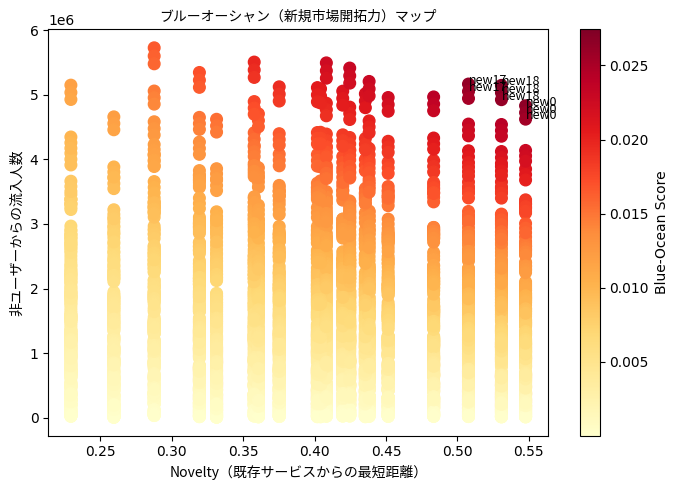

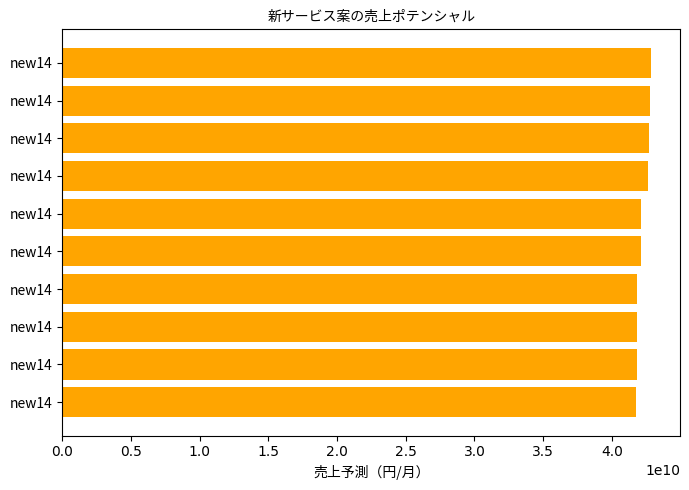

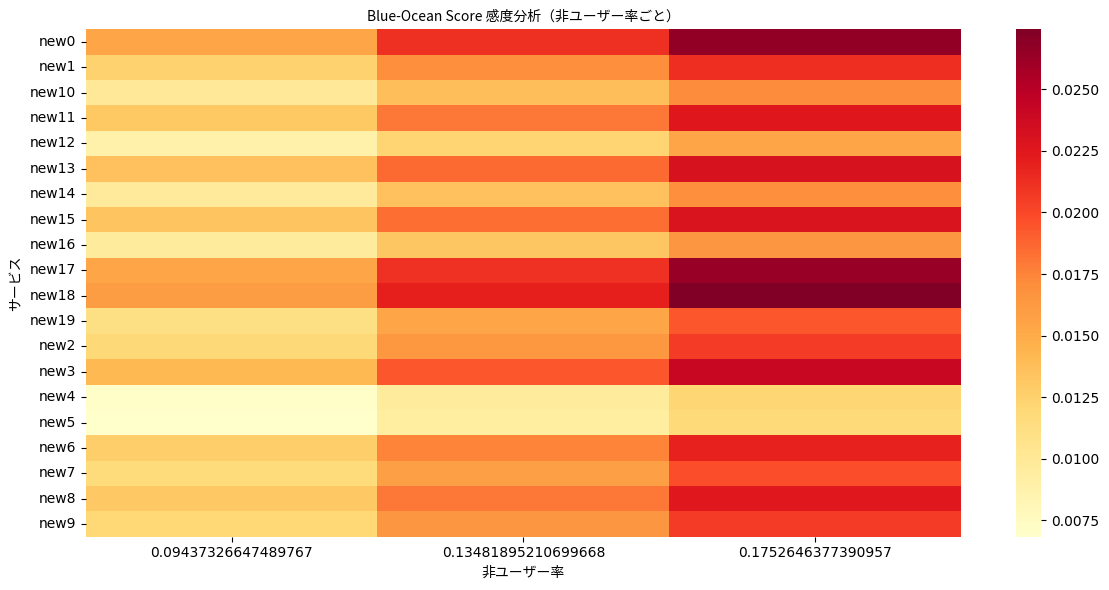

In [40]:
# =============================================================
# 4. ÂèØË¶ñÂåñ„Éª„É©„É≥„Ç≠„É≥„Ç∞Âá∫Âäõ
# =============================================================

print("=== Blue-Ocean Score TOP10 ===")
display(df_result.sort_values("BlueOceanScore", ascending=False).head(10))

plt.figure(figsize=(7,5))
plt.scatter(df_result["novelty"], df_result["from_nonuser"], 
            c=df_result["BlueOceanScore"], cmap="YlOrRd", s=70)
plt.colorbar(label="Blue-Ocean Score")
for _, row in df_result.sort_values("BlueOceanScore", ascending=False).head(8).iterrows():
    plt.text(row.novelty, row.from_nonuser, row.service, fontsize=9,
             fontproperties=font_prop)
plt.xlabel("NoveltyÔºàÊó¢Â≠ò„Çµ„Éº„Éì„Çπ„Åã„Çâ„ÅÆÊúÄÁü≠Ë∑ùÈõ¢Ôºâ", fontproperties=font_prop)
plt.ylabel("Èùû„É¶„Éº„Ç∂„Éº„Åã„Çâ„ÅÆÊµÅÂÖ•‰∫∫Êï∞", fontproperties=font_prop)
plt.title("„Éñ„É´„Éº„Ç™„Éº„Ç∑„É£„É≥ÔºàÊñ∞Ë¶èÂ∏ÇÂ†¥ÈñãÊãìÂäõÔºâ„Éû„ÉÉ„Éó", fontproperties=font_prop)
plt.tight_layout()
plt.show()

# Â£≤‰∏ä‰∫àÊ∏¨‰∏ä‰Ωç
plt.figure(figsize=(7,5))
order = np.argsort(df_result["estimated_sales"])[::-1][:10]
plt.barh(range(10), df_result.iloc[order]["estimated_sales"], color="orange")
plt.yticks(range(10), df_result.iloc[order]["service"], fontproperties=font_prop)
plt.xlabel("Â£≤‰∏ä‰∫àÊ∏¨ÔºàÂÜÜ/ÊúàÔºâ", fontproperties=font_prop)
plt.title("Êñ∞„Çµ„Éº„Éì„ÇπÊ°à„ÅÆÂ£≤‰∏ä„Éù„ÉÜ„É≥„Ç∑„É£„É´", fontproperties=font_prop)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ÊÑüÂ∫¶ÂàÜÊûêÁµêÊûú„Éí„Éº„Éà„Éû„ÉÉ„ÉóÔºà‰æãÔºö„Éë„É©„É°„Éº„Çø„Åî„Å®ÊúÄÂ§ßÂÄ§„Å™„Å©ÈõÜÁ¥ÑÔºâ
if args.sensitivity_analysis:
    pivot = df_result.pivot_table(index="service", columns="nonuser_mass", values="BlueOceanScore", aggfunc="max")
    plt.figure(figsize=(12,6))
    sns.heatmap(pivot, cmap="YlOrRd")
    plt.title("Blue-Ocean Score ÊÑüÂ∫¶ÂàÜÊûêÔºàÈùû„É¶„Éº„Ç∂„ÉºÁéá„Åî„Å®Ôºâ", fontproperties=font_prop)
    plt.ylabel("„Çµ„Éº„Éì„Çπ", fontproperties=font_prop)
    plt.xlabel("Èùû„É¶„Éº„Ç∂„ÉºÁéá", fontproperties=font_prop)
    plt.tight_layout()
    plt.show()

In [41]:
from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np

Y_fut  = np.load(args.fut)

# Êó¢Â≠ò„ÅÆ„Çµ„Éº„Éì„Çπ„ÅÆÂüã„ÇÅËæº„ÅøÔºà64Ê¨°ÂÖÉÔºâ„Å®ÂØæÂøú„Åô„Çã33Ê¨°ÂÖÉÁâπÂæ¥Èáè
X_train = np.load("../../data/shared/embeddings.npy")  # 64Ê¨°ÂÖÉ„ÅÆBYOLÁâπÂæ¥Èáè
feat_df = pd.read_pickle("../../data/shared/feat_df.pkl")  # 33Ê¨°ÂÖÉ„ÅÆÂÖÉ„ÅÆÁâπÂæ¥Èáè

y_train = feat_df.values  # 33Ê¨°ÂÖÉ„ÅÆÂÖÉ„ÅÆÁâπÂæ¥Èáè

# MLPÂõûÂ∏∞„ÇíÂ≠¶Áøí
reg = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500)
reg.fit(X_train, y_train)

# Êñ∞„Åó„ÅÑ„Çµ„Éº„Éì„ÇπÔºà64Ê¨°ÂÖÉÔºâ„ÅÆÁâπÂæ¥Èáè„Çí‰∫àÊ∏¨
X_new = reg.predict(Y_fut)  # Y_fut„ÅØ64Ê¨°ÂÖÉ„ÅÆÊñ∞„Çµ„Éº„Éì„ÇπÂüã„ÇÅËæº„Åø


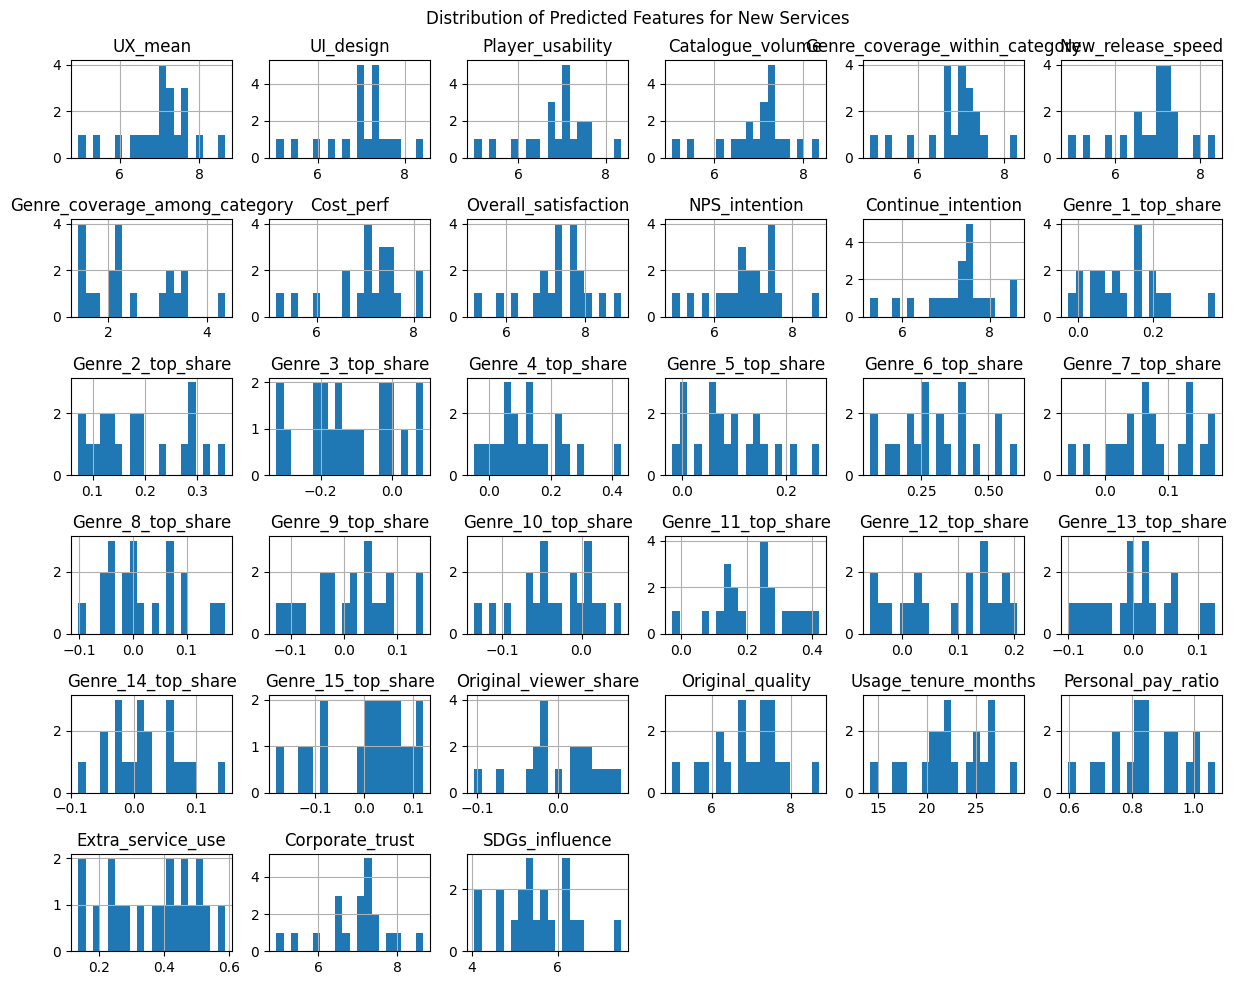

In [42]:
# Êñ∞„Çµ„Éº„Éì„Çπ„ÅÆÁâπÂæ¥Èáè„Çí„Éá„Éº„Çø„Éï„É¨„Éº„É†Âåñ
new_service_df = pd.DataFrame(X_new, columns=feat_df.columns)

# ÂêÑÁâπÂæ¥Èáè„ÇíÂèØË¶ñÂåñÔºà„Éí„Çπ„Éà„Ç∞„É©„É†„Å™„Å©Ôºâ
new_service_df.hist(figsize=(12, 10), bins=20)
plt.suptitle('Distribution of Predicted Features for New Services')
plt.tight_layout()
plt.show()

In [43]:
# Êñ∞„Çµ„Éº„Éì„Çπ„Å®ÂÖÉ„ÅÆ„Çµ„Éº„Éì„Çπ„ÅÆÁâπÂæ¥Èáè„ÅÆÂπ≥ÂùáÂ∑Æ„ÇíË®àÁÆó
avg_diff = np.abs(feat_df.values - X_new).mean(axis=0)

# ÊúÄ„ÇÇÂ∑ÆÂàÜ„ÅåÂ§ß„Åç„ÅÑÁâπÂæ¥Èáè„ÇíË°®Á§∫
top_diff_indices = np.argsort(avg_diff)[::-1][:10]
print("New service's most distinctive features:")
for idx in top_diff_indices:
    print(f"{feat_df.columns[idx]}: Difference {avg_diff[idx]:.3f}")


New service's most distinctive features:
Usage_tenure_months: Difference 6.632
Genre_coverage_among_category: Difference 1.524
Genre_coverage_within_category: Difference 1.032
SDGs_influence: Difference 1.020
Overall_satisfaction: Difference 1.018
NPS_intention: Difference 0.997
Corporate_trust: Difference 0.983
New_release_speed: Difference 0.967
Catalogue_volume: Difference 0.966
Continue_intention: Difference 0.937


In [44]:
# ÁúÅÁï•„Åõ„Åö„Å´ÂÖ®Âàó„ÉªÂÖ®Ë°å„ÇíË°®Á§∫„Åô„ÇãË®≠ÂÆö
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
new_service_df

UX_mean  UI_design  Player_usability  Catalogue_volume  \
0   7.638293   7.489064          7.382029          7.348829   
1   7.341222   7.156030          7.184092          7.107670   
2   6.979926   7.069180          6.698404          7.066962   
3   7.306710   7.341566          7.086402          7.418535   
4   8.653533   8.418718          8.348818          8.352394   
5   6.659186   6.929740          6.737949          6.777086   
6   5.444048   5.522469          5.427420          5.527364   
7   4.953657   5.053629          5.002522          5.066725   
8   7.553542   7.355565          7.376744          7.276980   
9   7.412313   7.317562          7.130399          7.245295   
10  8.012774   7.768383          7.672990          7.910711   
11  7.136112   7.267552          7.058867          7.253429   
12  7.681701   7.671525          7.514719          7.561878   
13  7.198565   7.314856          7.070189          7.326933   
14  6.528589   6.664627          6.476600          6.627386   
15  5.962302   5.986255          5.872415          6.086409   
16  7.133421   6.987780          7.061189          7.170362   
17  7.022614   6.908153          6.716585          6.832567   
18  6.398390   6.373495          6.277743          6.483075   
19  7.030051   7.066468          6.923170          6.993394   

    Genre_coverage_within_category  New_release_speed  \
0                         7.220789           7.267450   
1                         6.941215           7.133681   
2                         6.617707           6.970606   
3                         7.205311           7.330300   
4                         8.304242           8.352880   
5                         6.712453           6.613275   
6                         5.261173           5.323410   
7                         4.903677           4.892895   
8                         7.237531           7.222773   
9                         6.961974           7.263066   
10                        7.334737           7.868629   
11                        7.290125           7.070702   
12                        7.472164           7.479868   
13                        7.062228           7.211876   
14                        6.749248           6.232365   
15                        5.922559           5.894290   
16                        6.950301           7.126811   
17                        6.700258           6.753027   
18                        6.310156           6.478862   
19                        6.949011           6.820162   

    Genre_coverage_among_category  Cost_perf  Overall_satisfaction  \
0                        3.214193   7.490410              7.912097   
1                        3.092119   7.174273              7.631921   
2                        2.479214   7.049649              7.336734   
3                        2.199157   7.523690              7.689601   
4                        4.366811   8.195705              8.919476   
5                        1.451089   6.873888              6.963767   
6                        2.106219   5.583236              5.751158   
7                        1.630037   5.161460              5.183347   
8                        3.370444   7.368382              7.817017   
9                        2.272347   7.405951              7.731377   
10                       1.402840   8.176369              8.411765   
11                       2.012834   7.330591              7.415947   
12                       3.575748   7.528338              8.046881   
13                       1.468221   7.645758              7.650215   
14                       3.512096   6.606449              7.007774   
15                       1.818407   6.067842              6.179851   
16                       3.182327   7.083530              7.416433   
17                       2.228209   7.005507              7.210891   
18                       1.546196   6.617275              6.704254   
19                       2.165391   7.127215              7.334642   

    NPS_inte

In [45]:
# ‚îÄ‚îÄ ‚ë† new15 „ÅÆË°å„ÇíÂèñ„ÇäÂá∫„Åô ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
row15 = df_result.query("service == 'new15'").iloc[0]

# ‚îÄ‚îÄ ‚ë° ÊµÅÂÖ•‰∫∫Êï∞„Å´Â§âÊèõÔºàÁéá √ó Â∏ÇÂ†¥Ë¶èÊ®°Ôºâ ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
#     ‚Äª „Åô„Åß„Å´ run_ot_for_candidate() ÂÜÖ„Åß total_market_size „ÇíÊéõ„Åë„Å¶
#       'total_inflow' „Å´Áµ∂ÂØæ‰∫∫Êï∞„ÅåÂÖ•„Å£„Å¶„ÅÑ„ÇãÂ†¥Âêà„ÅØ‚Üì‰∏çË¶Å
inbound_users = row15["total_inflow"]                 # ‰∫∫
print(f"ÊÉ≥ÂÆöÊµÅÂÖ•‰∫∫Êï∞: {inbound_users:,.0f} ‰∫∫")

# ‚îÄ‚îÄ ‚ë¢ Âçò‰æ°„ÇíÊéõ„Åë„Å¶ÊúàÊ¨°ÔºèÁ¥ØË®àÂ£≤‰∏ä„ÇíÊé®Ë®à ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
monthly_fee      = 690           # ÂÜÜ
avg_tenure_month = 17.7          # Êúà
monthly_sales    = inbound_users * monthly_fee
lifetime_sales   = monthly_sales * avg_tenure_month

print(f"ÊúàÊ¨°Â£≤‰∏ä‰∫àÊ∏¨ : ¬•{monthly_sales:,.0f}")
print(f"LTV Â£≤‰∏ä‰∫àÊ∏¨: ¬•{lifetime_sales:,.0f}  (Á∂ôÁ∂ö {avg_tenure_month} „ÉµÊúà)")


ÊÉ≥ÂÆöÊµÅÂÖ•‰∫∫Êï∞: 634,749 ‰∫∫
ÊúàÊ¨°Â£≤‰∏ä‰∫àÊ∏¨ : ¬•437,977,104
LTV Â£≤‰∏ä‰∫àÊ∏¨: ¬•7,752,194,749  (Á∂ôÁ∂ö 17.7 „ÉµÊúà)
